# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [397]:
import numpy as np
import doctest
import matplotlib.pyplot as plt
import pandas as pd
import math

seed=4221724

## Data Generation

In [398]:
def gen_data(n, y_min, alpha, mu, c, seed=1):
    
  # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha neds to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)[::-1]
    d = np.sort(d)

   
    return y, d

## Data Gen Validation

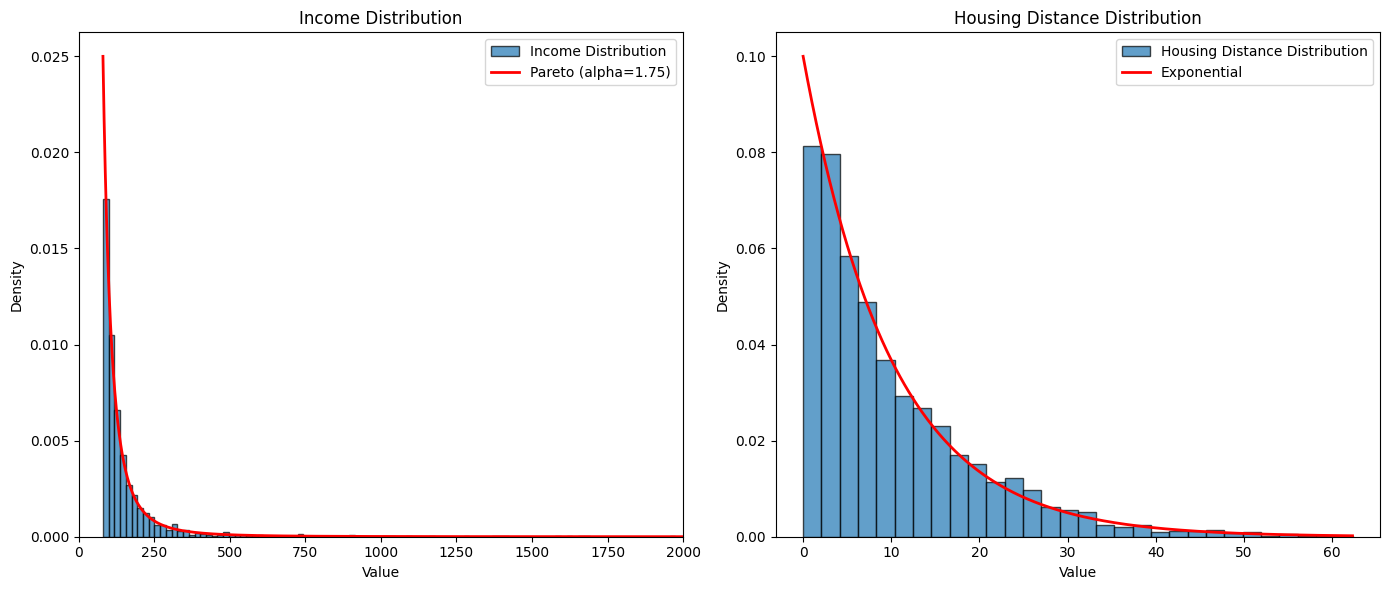

Income: [1974.38519417 1676.96898652 1654.98553312 ...   80.02435681   80.01572476
   80.00565381]
Housing Distance: [6.24825322e-03 1.01994555e-02 2.23983408e-02 ... 5.72442032e+01
 5.82885486e+01 6.23108647e+01]


In [399]:

# PLOT DISTRIBUTIONS 

def plot_distributions(n,y_min,alpha,mu,c,seed,xlim):
    
    y,d,=gen_data(n, y_min, alpha, mu, c, seed)

    # check to see if they look pareto and exp
    
    plt.figure(figsize=(14, 6))  

    # Income Distribution
    plt.subplot(1, 2, 1)
    plt.hist(y, bins=100, density=True, alpha=0.7, edgecolor="black", label="Income Distribution")
    plt.title("Income Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.xlim(0, xlim) 

    # Add Pareto line
    pareto_x = np.linspace(y_min, xlim, xlim)
    pareto_pdf = (alpha * y_min**alpha) / (pareto_x ** (alpha + 1))
    plt.plot(pareto_x, pareto_pdf, 'r-', lw=2, label="Pareto (alpha=1.75)")
    plt.legend()

    # Housing Distance Distribution
    plt.subplot(1, 2, 2)
    plt.hist(d, bins=30, density=True, alpha=0.7, edgecolor="black", label="Housing Distance Distribution")
    plt.title("Housing Distance Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")

    # Add Exponential line
    exp_x = np.linspace(0, d.max(), 500)
    exp_pdf = (1 / mu) * np.exp(-exp_x / mu)
    plt.plot(exp_x, exp_pdf, 'r-', lw=2, label="Exponential")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(f'Income: {y}')
    print(f'Housing Distance: {d}')


# Generate samples for visualization
n_test = 2000
y_min_test = 80
alpha_test = 2
mu_test = 10
c_test = 50


plot_distributions(n_test,y_min_test,alpha_test,mu_test,c_test,seed,xlim=2000) #xlim for readibility



## Visualization and Statistics

In [400]:
def compute_statistics(prices):
    average = float(round(np.mean(prices), 2))
    median = float(round(np.median(prices), 2))
    Q1 = float(round(np.percentile(prices, 25), 2))
    Q3 = float(round(np.percentile(prices, 75), 2))    
    IQR = float(round(Q3 - Q1, 2))

    statistics = {
        'average': average,
        'median': median,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }
    return statistics


def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(1, 0, n)

    plt.figure(figsize=(8, 3))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(1, 0, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_house_prices(y, prices)
#plot_percentage_income_spent(y, prices)
#print(compute_statistics(prices))

## 2a: basic recursion

In [401]:
def get_price_recursive(j, n, c, y, d):
    # Input checks:
    if j < 1 or j > n:
        raise ValueError("invalid j")

    # Base case: p_n = c
    if j == n:
        return c

    # Recursive step:
    theta_j = math.exp(-(d[j] - d[j-1]))  # d[j] = d_j+1
    
    # Using 0-based indexing: y[j] is y_j+1
    p_j_plus_1 = get_price_recursive(j+1, n, c, y, d)
    
    p_j = theta_j * p_j_plus_1 + (1 - theta_j) * y[j]  # y[j] = y_j+1
    return p_j

# create price array
def calc_prices_recursive(n, c, y, d):
    prices = []
    for j in range(1, n+1):
        p_j = get_price_recursive(j, n, c, y, d)
        prices.append(p_j)
    return prices

## 2b: memo

In [402]:
def calc_price_memo(n, c, y, d):
    memo = np.full(n+1, np.nan)  # index 0 won't be used
    memo[n] = c  # Base case: p_n = c

    def calc_equilibrium_memo(j):
        if not np.isnan(memo[j]):
                return memo[j]
        else:        
                # Calculate theta_j using 1-based indexing
            theta_j = np.exp(-(d[j] - d[j-1]))
                
                # Recursive calculation for the next price (j+1)
            next_price = calc_equilibrium_memo(j + 1)
                
                # Calculate current equilibrium price using y[j] for y_{j+1}
            memo[j] = theta_j * next_price + (1 - theta_j) * y[j]
            return memo[j]
            # Compute prices from n-1 down to 1
    for j in range(n-1, 0, -1):
        calc_equilibrium_memo(j)
    return memo[1:]

## 2c: Iterative 

In [403]:

def calc_prices_iterative(n, c, y, d):
    if not all(y[i] >= y[i+1] for i in range(n-1)):
        raise ValueError("Incomes y must be sorted in descending order.")
    if not all(d[i] <= d[i+1] for i in range(n-1)):
        raise ValueError("Distances d must be sorted in ascending order.")

    prices = [0] * n
    prices[-1] = c  # p_n = c

    for j in range(n-2, -1, -1):  # from p_{n-1} to p_1
        theta_j = math.exp(-(d[j+1] - d[j]))
        prices[j] = theta_j * prices[j+1] + (1 - theta_j) * y[j+1]
    
    return prices

## 4a

   y_min  average  median      Q1      Q3     IQR
0     80   136.51  111.99   92.35  152.26   59.91
1    100   172.58  142.39  116.61  199.60   82.99
2    150   257.34  210.73  172.88  293.95  121.07


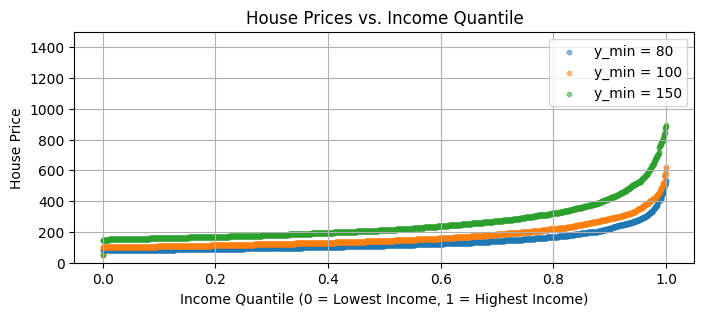

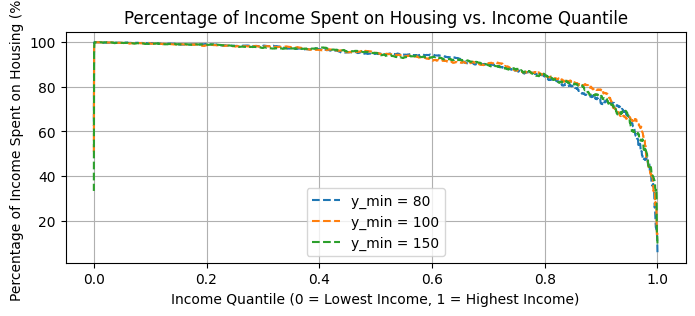

In [404]:
n = 2000
y_min_list = [80, 100, 150]
alpha = 1.75
mu = 10
c = 50

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each y_min value
for y_min in y_min_list:
    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
   
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['y_min'] = y_min  
    stats_list.append(stats)
    
    # Test base case
   # base_case_price = prices[0]  # This is the price of house j=1
   # if base_case_price == c:
   #     base_case_result = f"Base Case check passed: {base_case_price}"
  #  else:
   #     base_case_result = f"Base Case check failed: {base_case_price}"

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)


# Create plots after the loop
income_quantiles = np.linspace(1, 0, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(8, 3))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'y_min = {y_min}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(8, 3))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()



### 4b

   alpha  average  median     Q1      Q3     IQR
0   1.25   191.64  129.66  98.47  203.29  104.82
1   1.75   138.82  112.00  91.96  159.80   67.84
2   3.00   106.60   97.27  86.86  116.44   29.58


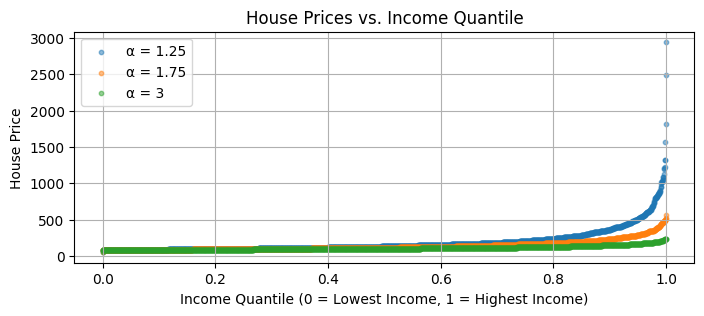

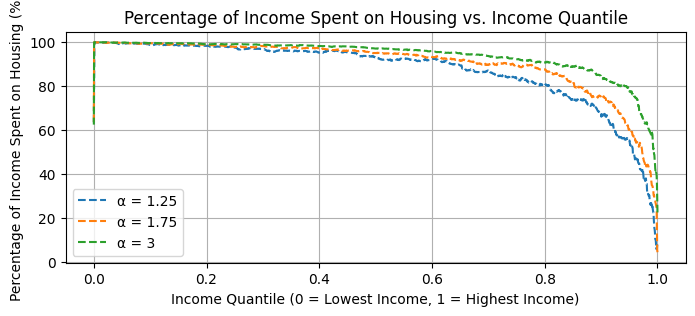

In [405]:
n = 2000
alpha_list = [1.25, 1.75, 3]
y_min = 80
mu = 10
c = 50

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each alpha
for alpha in alpha_list:

    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['alpha'] = alpha  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['alpha', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(1, 0, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(8, 3))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {alpha}')  

#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(8, 3))
for i, (y, prices, alpha) in enumerate(zip(all_y, all_prices, alpha_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {alpha}') 
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

### 4c

   mu  average  median     Q1      Q3    IQR
0   5   127.43  109.57  90.95  147.33  56.38
1  10   136.03  112.11  91.32  150.96  59.64
2  20   149.66  114.78  92.30  166.64  74.34


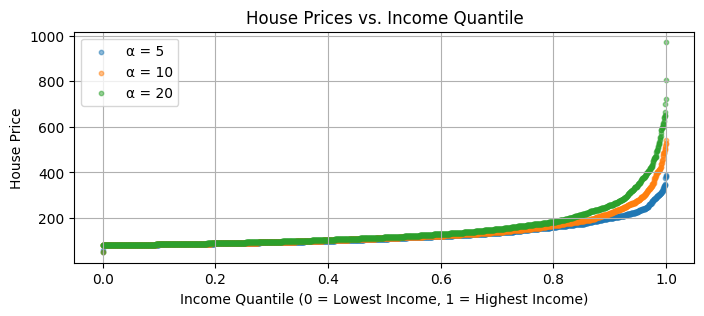

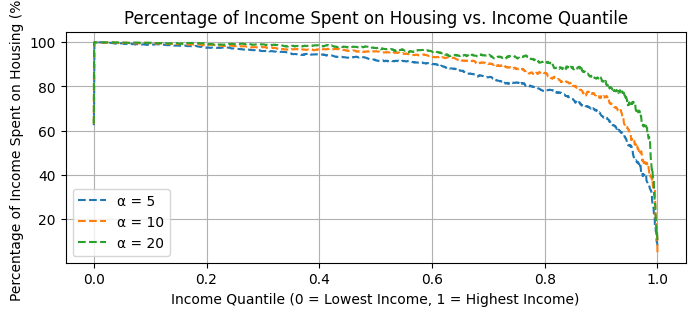

In [406]:
n = 2000
mu_list = [5,10,20]
y_min = 80
alpha = 1.75
c = 50


# Initialize lists to collect statistics and data
stats_list = []
all_y = []  # Store income data
all_prices = []  # Store price data

# Iterate over each alpha
for mu in mu_list:

    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['mu'] = mu  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]  
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(1, 0, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(8, 3))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {mu}') 
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(8, 3))
for i, (y, prices, mu) in enumerate(zip(all_y, all_prices, mu_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {mu}')  # Fixed: Label shows alpha
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Population Growth

## Building up

      n  average  median     Q1      Q3    IQR
0  2000   137.04  114.00  92.22  157.79  65.57
1  4000   136.03  112.58  92.89  153.23  60.34


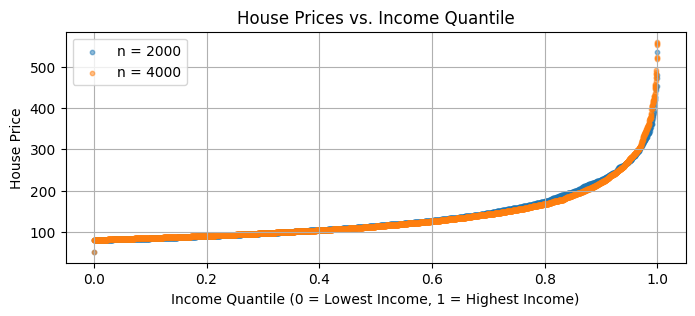

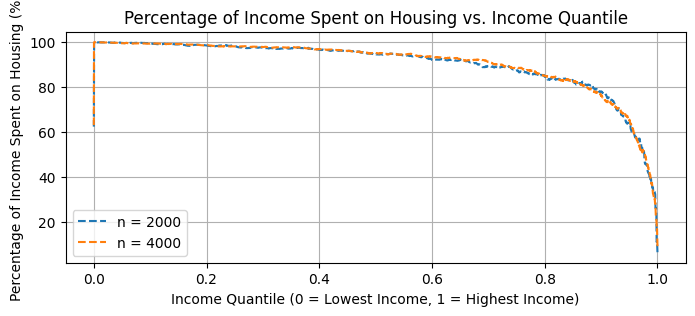

In [407]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
mu = 10
c = 50

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices


for n in n_list:

    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d) # the regular recursive approach does not work with n=4000
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n  
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(8, 3))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'n = {n}')
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(8, 3))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'n = {n}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()


## Building out

      n  mu  average  median     Q1      Q3    IQR
0  2000  10   137.56  113.31  91.93  154.26  62.33
1  4000  20   147.23  116.43  93.30  165.26  71.96


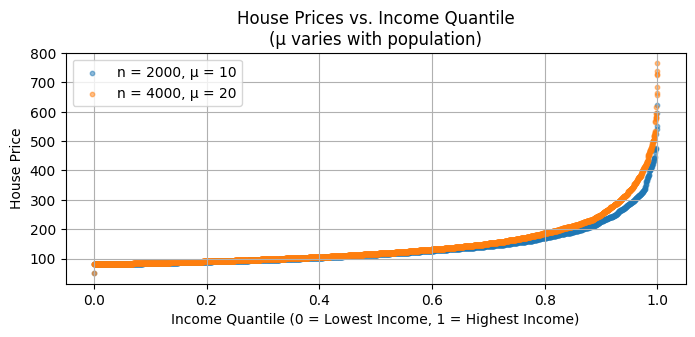

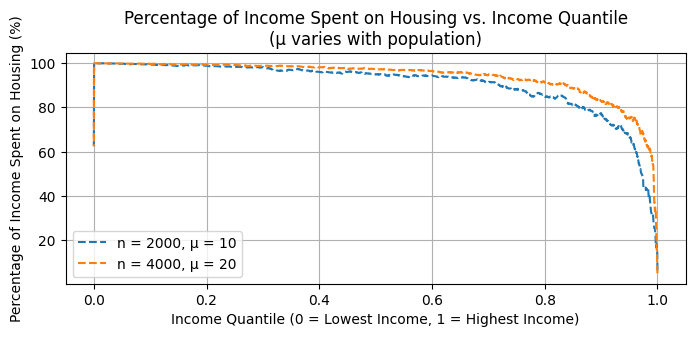

In [408]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
c = 50
stats_list = []  # Store stats for table
all_y = []       # Store income data
all_prices = []  # Store prices

# Create dictionary mapping population sizes to mu values
mu_dict = {2000: 10, 4000: 20}  # mu doubles for larger population

for n in n_list:
    # Get appropriate mu for this population size
    mu = mu_dict[n]
    
    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    all_y.append(y)
    all_prices.append(prices)
   
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n
    stats_i['mu'] = mu  # Add mu to statistics for reference
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(8, 3))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, 
                label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(8, 3))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', 
             label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

## 7

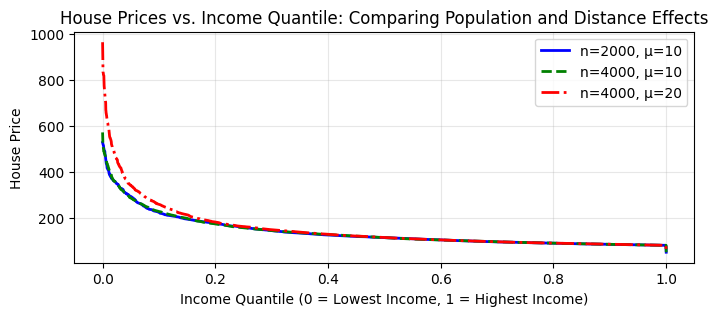

In [409]:
# define dictionary of scenarios because two of the variables change
scenarios = [
    {'n': 2000, 'mu': 10, 'label': 'n=2000, μ=10'},
    {'n': 4000, 'mu': 10, 'label': 'n=4000, μ=10'},
    {'n': 4000, 'mu': 20, 'label': 'n=4000, μ=20'}
]

alpha = 1.75
y_min = 80
c = 50

# Store results
all_prices = []
all_quantiles = []

# Generate data for each scenario
for scenario in scenarios:
    n = scenario['n']
    mu = scenario['mu']
    
    # Generate data and calculate prices
    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store results
    all_prices.append(prices)
    all_quantiles.append(np.linspace(0, 1, len(prices)))

# plot comparison
plt.figure(figsize=(8, 3))

styles = ['-', '--', '-.']
colors = ['blue', 'green', 'red']

for (prices, quantiles, scenario, style, color) in zip(all_prices, all_quantiles, scenarios, styles, colors):
    plt.plot(quantiles, prices, 
             linestyle=style,
             color=color,
             label=scenario['label'],
             linewidth=2)

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile: Comparing Population and Distance Effects')
plt.grid(True, alpha=0.3)
plt.legend()

#plt.xlim(0.98, 1.01) # zoom in

plt.show()



# Check/Debugging

In [410]:
def check(n, y, d, prices, filename="check.csv"):
 

    # Create a DataFrame with agent information
        data = {
            'Agent': list(range(1, n + 1)),  # Agents numbered from 1 to n
            'Income': y,
            'Distance': d,
            'Price_iterative': prices,
            'Prices_recursive': prices_recursive,
            'Prices_memo': prices_memo
        }
        
        df = pd.DataFrame(data)
        
        # Save to Excel
        df.to_csv(filename, index=False)
        print(f"Data successfully saved to '{filename}'")
        
  
n = 2000
y_min = 80
alpha = 1.75
mu = 10
c = 50

# Generate data
y, d = gen_data(n, y_min, alpha, mu, c, seed)

# Calculate equilibrium prices
prices = calc_prices_iterative(n, c, y, d)
prices_recursive = calc_prices_recursive(n, c, y, d)
prices_memo = calc_price_memo(n, c, y, d)

# Save to csv
check(n, y, d, prices)


Data successfully saved to 'check.csv'


# Tax

## Data gen

In [411]:
def gen_data_with_tax(n,y_min,alpha,mu,c,tau,seed):

    # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha needs to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")
    if not 0 <= tau < 1:
        raise ValueError("tau must be between 0 and 1")
        
    np.random.seed(seed)
# gen pretax income    
    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

# gen distances     
    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)
    
    # Sort both arrays
    y = np.sort(y)
    d = np.sort(d)
    
    
    y_bar = np.mean(y)
    
    # Calculate transfer (T = τ * y_bar)
    T = tau * y_bar
    
# Calculate post tax income
    x = (1 - tau) * y + T
    x = np.sort(x)
    return y, x, d # returnning y just in case we want to use it

## Plotting

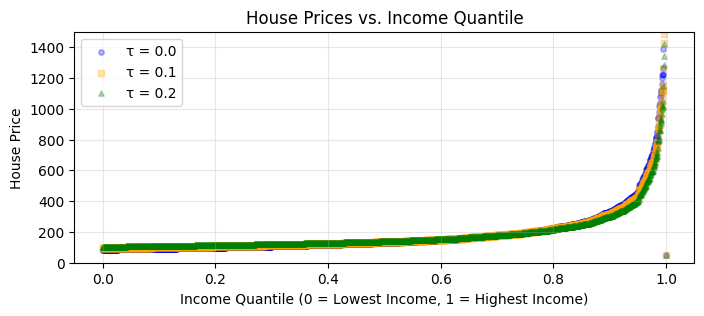

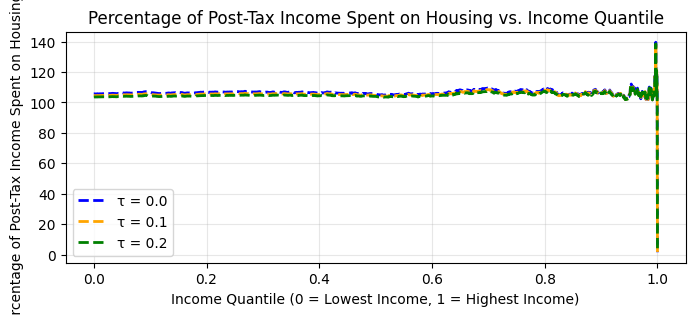

In [412]:
n=2000
y_min=80
alpha=1.75
mu=10
c=50
tau_list=[0.0,0.1,0.2]
seed=1

# Store data for all tax rates
all_y = []      # pre-tax incomes
all_x = []      # post-tax incomes
all_prices = []
for tau in tau_list:
    y, x, d = gen_data_with_tax(n, y_min, alpha, mu, c, tau, seed)
    prices = calc_prices_recursive(n, c, x, d)  # using post tax income (x) for calculations 
    all_y.append(y)
    all_x.append(x)
    all_prices.append(prices)

income_quantiles = np.linspace(0, 1, n)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(8, 3))
colors = ['blue', 'orange', 'green']
markers = ['o', 's', '^']
for prices, tau, color, marker in zip(all_prices, tau_list, colors, markers):
    plt.scatter(income_quantiles, prices, 
               s=15,
               alpha=0.3,
               color=color,
               marker=marker,
               label=f'τ = {tau}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent (using post-tax income)
plt.figure(figsize=(8, 3))
for x, prices, tau, color in zip(all_x, all_prices, tau_list, colors):  # Using x 
    percentage_spent = np.where(x != 0, (prices / x) * 100, 0)  # using x
    plt.plot(income_quantiles, percentage_spent, 
            linestyle='--', 
            color=color,
            linewidth=2,
            label=f'τ = {tau}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Post-Tax Income Spent on Housing (%)') 
plt.title('Percentage of Post-Tax Income Spent on Housing vs. Income Quantile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# All in one approach

y_min = 80
{'average': 139.4, 'median': 114.67, 'Q1': 93.04, 'Q3': 153.55, 'IQR': 60.51}

y_min = 100
{'average': 170.63, 'median': 139.99, 'Q1': 115.44, 'Q3': 190.33, 'IQR': 74.89}

y_min = 150
{'average': 258.86, 'median': 213.59, 'Q1': 174.92, 'Q3': 299.4, 'IQR': 124.48}



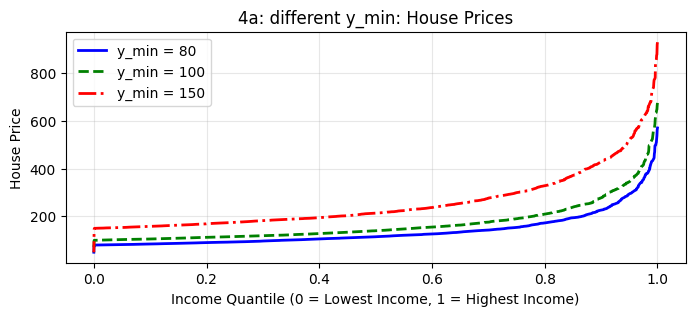

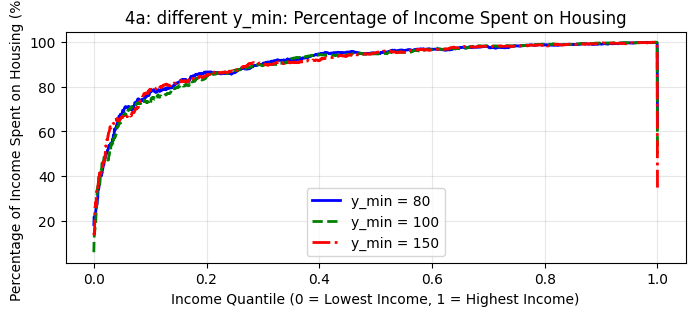

α = 1.25
{'average': 182.5, 'median': 128.82, 'Q1': 97.59, 'Q3': 205.8, 'IQR': 108.21}

α = 1.75
{'average': 140.31, 'median': 112.91, 'Q1': 92.79, 'Q3': 155.41, 'IQR': 62.62}

α = 3.00
{'average': 107.33, 'median': 97.33, 'Q1': 86.77, 'Q3': 119.64, 'IQR': 32.87}



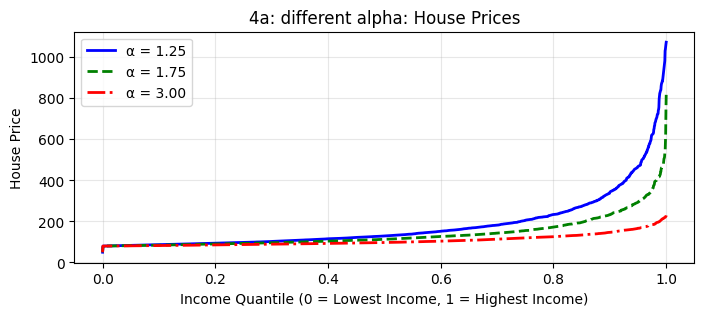

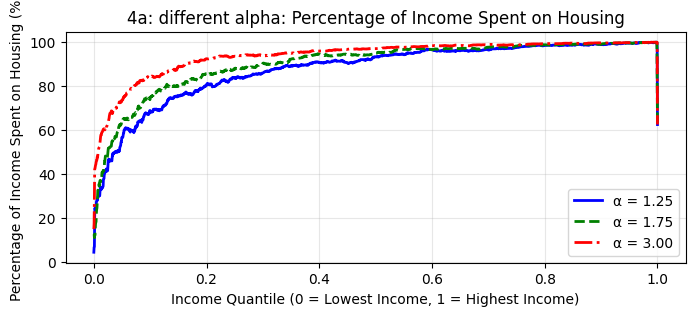

μ = 5
{'average': 126.0, 'median': 108.35, 'Q1': 90.89, 'Q3': 140.85, 'IQR': 49.96}

μ = 10
{'average': 138.26, 'median': 113.45, 'Q1': 92.1, 'Q3': 159.95, 'IQR': 67.85}

μ = 20
{'average': 146.37, 'median': 114.41, 'Q1': 92.05, 'Q3': 159.26, 'IQR': 67.21}



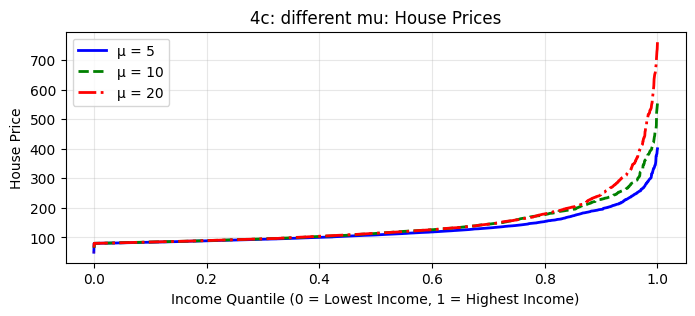

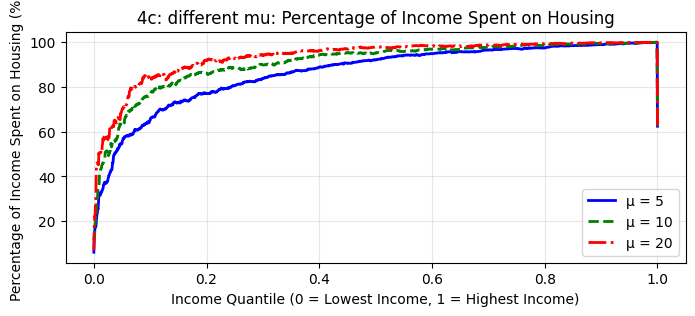

n=2000, μ=10
{'average': 138.99, 'median': 112.48, 'Q1': 91.55, 'Q3': 157.3, 'IQR': 65.75}

n=4000, μ=10
{'average': 140.35, 'median': 115.06, 'Q1': 92.64, 'Q3': 159.42, 'IQR': 66.78}

n=4000, μ=20
{'average': 147.13, 'median': 115.82, 'Q1': 93.64, 'Q3': 165.58, 'IQR': 71.94}



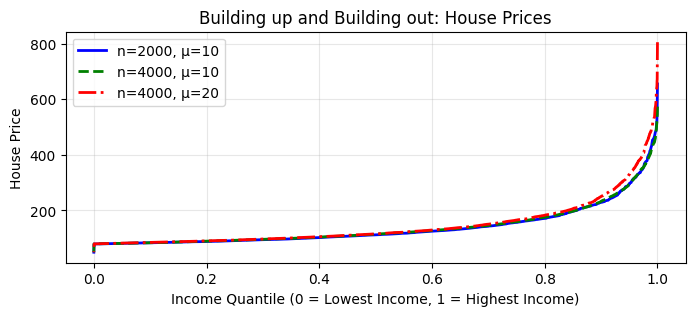

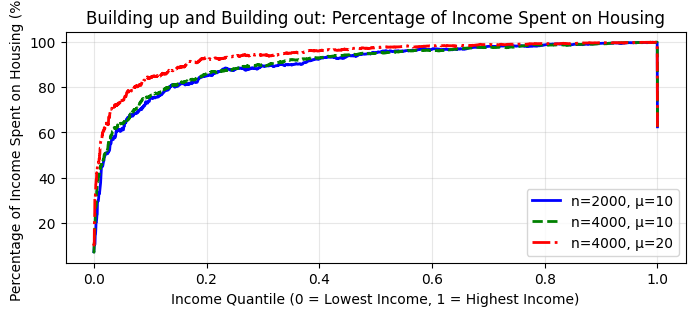

In [413]:
scenarios = [
    # 4a: Varying y_min
    {"y_min": 80, "n": 2000, "mu": 10, "c": 50, "alpha": 1.75, "label": "y_min = 80"},
    {"y_min": 100, "n": 2000, "mu": 10, "c": 50, "alpha": 1.75, "label": "y_min = 100"},
    {"y_min": 150, "n": 2000, "mu": 10, "c": 50, "alpha": 1.75, "label": "y_min = 150"},
    
    # 4b: Varying alpha
    {"alpha": 1.25, "y_min": 80, "n": 2000, "mu": 10, "c": 50, "label": "α = 1.25"},
    {"alpha": 1.75, "y_min": 80, "n": 2000, "mu": 10, "c": 50, "label": "α = 1.75"},
    {"alpha": 3.00, "y_min": 80, "n": 2000, "mu": 10, "c": 50, "label": "α = 3.00"},
    
    # 4c: Varying mu
    {"mu": 5, "y_min": 80, "n": 2000, "c": 50, "alpha": 1.75, "label": "μ = 5"},
    {"mu": 10, "y_min": 80, "n": 2000, "c": 50, "alpha": 1.75, "label": "μ = 10"},
    {"mu": 20, "y_min": 80, "n": 2000, "c": 50, "alpha": 1.75, "label": "μ = 20"},
   
    # Building up and out
    {"n": 2000, "mu": 10, "y_min": 80, "c": 50, "alpha": 1.75, "label": "n=2000, μ=10"},
    {"n": 4000, "mu": 10, "y_min": 80, "c": 50, "alpha": 1.75, "label": "n=4000, μ=10"},
    {"n": 4000, "mu": 20, "y_min": 80, "c": 50, "alpha": 1.75, "label": "n=4000, μ=20"}
]

def plot_scenario_group(scenario_group, title_base, zoom=False):
 
    # Store results
    all_prices = []
    all_quantiles = []
    all_y = []
    labels = []
    
    # Generate data for each scenario
    for scenario in scenario_group:
        # Generate data and calculate prices
        y, d = gen_data(scenario['n'], scenario['y_min'], scenario['alpha'], 
                       scenario['mu'], scenario['c'], seed)
        prices = calc_prices_iterative(scenario['n'], scenario['c'], y, d)
        
        print(scenario['label'])
        print(compute_statistics(prices))
        print()

        # Store results
        all_prices.append(prices)
        all_quantiles.append(np.linspace(1, 0, len(prices)))
        all_y.append(y)
       

    # First plot: House Prices
    plt.figure(figsize=(8, 3))
    styles = ['-', '--', '-.']
    colors = ['blue', 'green', 'red']
    
    for (prices, quantiles, scenario, style, color) in zip(
            all_prices, all_quantiles, scenario_group, styles, colors):
        plt.plot(quantiles, prices, 
                linestyle=style,
                color=color,
                label=scenario['label'],
                linewidth=2)
    
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title(f'{title_base}: House Prices')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    if zoom:
        plt.xlim(0.98, 1.01)
    
    plt.show()
    
    # Second plot: Percentage of Income Spent
    plt.figure(figsize=(8, 3))
    
    for (y, prices, scenario, style, color) in zip(
            all_y, all_prices, scenario_group, styles, colors):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
        plt.plot(np.linspace(0, 1, len(y)), percentage_spent,
                linestyle=style,
                color=color,
                label=scenario['label'],
                linewidth=2)
    
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title(f'{title_base}: Percentage of Income Spent on Housing')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Plot each group using slices of your scenarios list
plot_scenario_group(scenarios[0:3], 
                   '4a: different y_min')

plot_scenario_group(scenarios[3:6],
                   '4a: different alpha')

plot_scenario_group(scenarios[6:9],
                   '4c: different mu')

plot_scenario_group(scenarios[9:12],
                   'Building up and Building out')



# Low Income Housing

In [414]:


def gen_data_restricted(n, y_min, alpha, mu, c, seed=1):
   
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha needs to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")
    if n % 2 != 0:
        raise ValueError("n must be even")

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate incomes using a Pareto-like distribution
    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    # Generate house distances using an exponential distribution
    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    # Sort incomes in descending order and distances in ascending order
    y = np.sort(y)[::-1]
    d = np.sort(d)

    # Identify restricted houses: every third house (1-based indexing: 3, 6, 9, ...)
    # In 0-based indexing: indices 2, 5, 8, ...
    restricted_houses = np.zeros(n, dtype=bool)
    restricted_houses[2::3] = True  # Set every third house as restricted

    # Split agents into high-income and low-income groups
    # Since n is even, the median splits the agents exactly in half
    m = n // 2
    high_income_agents = np.zeros(n, dtype=bool)
    high_income_agents[:m] = True          # First half are high-income
    low_income_agents = ~high_income_agents  # Second half are low-income

    return y, d, restricted_houses, high_income_agents, low_income_agents

def allocate_houses(y, d, restricted_houses, high_income_agents, low_income_agents):
   
    n = len(y)
    m = n // 2

    # Identify restricted and unrestricted houses
    restricted = np.where(restricted_houses)[0]
    unrestricted = np.where(~restricted_houses)[0]

    # High-income agents: first m agents
    high_agents = np.arange(m)
    # Low-income agents: last m agents
    low_agents = np.arange(m, n)

    # Number of unrestricted houses must be >= m
    if len(unrestricted) < m:
        raise ValueError("Not enough unrestricted houses for high-income agents.")

    # Assign the closest m unrestricted houses to high-income agents
    # Unrestricted houses are sorted ascendingly
    # Assign to high agents sorted by y descendingly
    high_agents_sorted = high_agents[np.argsort(-y[high_agents])]
    allocated_unrestricted = unrestricted[:m]
    # Create mapping: agent -> house
    high_allocation = dict(zip(high_agents_sorted, allocated_unrestricted))

    # Assign restricted houses to low-income agents
    # Restricted houses are sorted ascendingly
    low_agents_sorted = low_agents[np.argsort(-y[low_agents])]
    allocated_restricted = restricted[:len(low_agents_sorted)]
    low_allocation = {}
    for agent, house in zip(low_agents_sorted, allocated_restricted):
        low_allocation[agent] = house

    # If more low-income agents than restricted houses, assign remaining to unrestricted houses
    if len(low_agents_sorted) > len(restricted):
        extra_low_agents = low_agents_sorted[len(restricted):]
        # Assign to the farthest unrestricted houses not allocated to high-income agents
        remaining_unrestricted = unrestricted[m:]
        # Sort remaining unrestricted houses in descending order (farthest first)
        remaining_unrestricted_sorted = np.sort(remaining_unrestricted)[::-1]
        if len(remaining_unrestricted_sorted) < len(extra_low_agents):
            raise ValueError("Not enough unrestricted houses for low-income agents.")
        allocated_extra_unrestricted = remaining_unrestricted_sorted[:len(extra_low_agents)]
        for agent, house in zip(extra_low_agents, allocated_extra_unrestricted):
            low_allocation[agent] = house

    # Combine allocations
    agent_house = np.full(n, -1, dtype=int)
    for agent, house in high_allocation.items():
        agent_house[agent] = house
    for agent, house in low_allocation.items():
        agent_house[agent] = house

    # Verify all agents have been allocated
    if -1 in agent_house:
        raise ValueError("Not all agents have been allocated a house.")

    return agent_house

def compute_prices(y, d, agent_house, c, restricted_houses):
    n = len(y)
    p = np.full(n, c)

    # Split into high-income and low-income submarkets
    m = n // 2
    high_agents = np.arange(m)
    low_agents = np.arange(m, n)

    # Find houses allocated to high and low agents
    high_houses = agent_house[high_agents]
    low_houses = agent_house[low_agents]

    # Sort high_houses ascendingly (closest first)
    high_houses_sorted = np.sort(high_houses)
    # Sort high_agents by descending y
    high_agents_sorted_by_y = high_agents[np.argsort(-y[high_agents])]

    # Sort low_houses ascendingly (closest first)
    low_houses_sorted = np.sort(low_houses)
    # Sort low_agents by descending y
    low_agents_sorted_by_y = low_agents[np.argsort(-y[low_agents])]

    # Compute prices for high-income submarket
    m_high = len(high_houses_sorted)
    if m_high > 0:
        p_high = np.zeros(m_high)
        # Initialize the farthest house price to c
        p_high[-1] = max(c, c)  # Ensures price is at least c
        # Iterate from the second farthest to the closest house
        for j in range(m_high - 2, -1, -1):
            delta_d = d[high_houses_sorted[j+1]] - d[high_houses_sorted[j]]
            theta = np.exp(-delta_d)
            # y_next is the income of the next lower-income high-agent
            y_next = y[high_agents_sorted_by_y[j+1]]
            p_high[j] = theta * p_high[j+1] + (1 - theta) * y_next
            p_high[j] = max(p_high[j], c)
        # Assign computed prices to the corresponding houses
        p[high_houses_sorted] = p_high

    # Compute prices for low-income submarket
    m_low = len(low_houses_sorted)
    if m_low > 0:
        p_low = np.zeros(m_low)
        # Initialize the farthest house price to c
        p_low[-1] = max(c, c)  # Ensures price is at least c
        # Iterate from the second farthest to the closest house
        for j in range(m_low - 2, -1, -1):
            delta_d = d[low_houses_sorted[j+1]] - d[low_houses_sorted[j]]
            theta = np.exp(-delta_d)
            # y_next is the income of the next lower-income low-agent
            y_next = y[low_agents_sorted_by_y[j+1]]
            p_low[j] = theta * p_low[j+1] + (1 - theta) * y_next
            p_low[j] = max(p_low[j], c)
        # Assign computed prices to the corresponding houses
        p[low_houses_sorted] = p_low

    return p

def create_dataframe(y, d, p, agent_house, restricted_houses):
    n = len(y)
    agent_ids = np.arange(1, n+1)
    assigned_houses = agent_house + 1  # Convert to 1-based indexing for readability
    low_income_house = restricted_houses[agent_house]

    agent_df = pd.DataFrame({
        'Agent_ID': agent_ids,
        'Income_y': y,
        'House_ID': assigned_houses,
        'House_Distance_d': d[agent_house],
        'House_Price_p': p[agent_house],
        'Low_Income_House': low_income_house
    })
    return agent_df

def save_to_excel(df, filename="agent_allocation.xlsx"):
    """
    Saves the DataFrame to an Excel file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - filename (str): The name of the Excel file.
    """
    try:
        df.to_excel(filename, index=False)
        print(f"DataFrame successfully saved to '{filename}'.")
    except Exception as e:
        print(f"An error occurred while saving to Excel: {e}")

    # Define parameters
    n=2000
    y_min=80
    alpha=1.75
    mu=10
    c=50    

    # Step 1: Generate Data
    y, d, restricted_houses, high_income_agents, low_income_agents = gen_data_restricted(n, y_min, alpha, mu, c, seed)

    # Step 2: Allocate Houses
    agent_house = allocate_houses(y, d, restricted_houses, high_income_agents, low_income_agents)

    # Step 3: Compute Equilibrium Prices
    p = compute_prices(y, d, agent_house, c, restricted_houses)

    # Step 4: Create DataFrame with Low-Income House Indicator
    df = create_dataframe(y, d, p, agent_house, restricted_houses)

    # Display the DataFrame
    print("Agent Allocation and Pricing DataFrame:")
    print(df)

    # Step 5: Save DataFrame to Excel
    save_to_excel(df, filename="agent_allocation.xlsx")


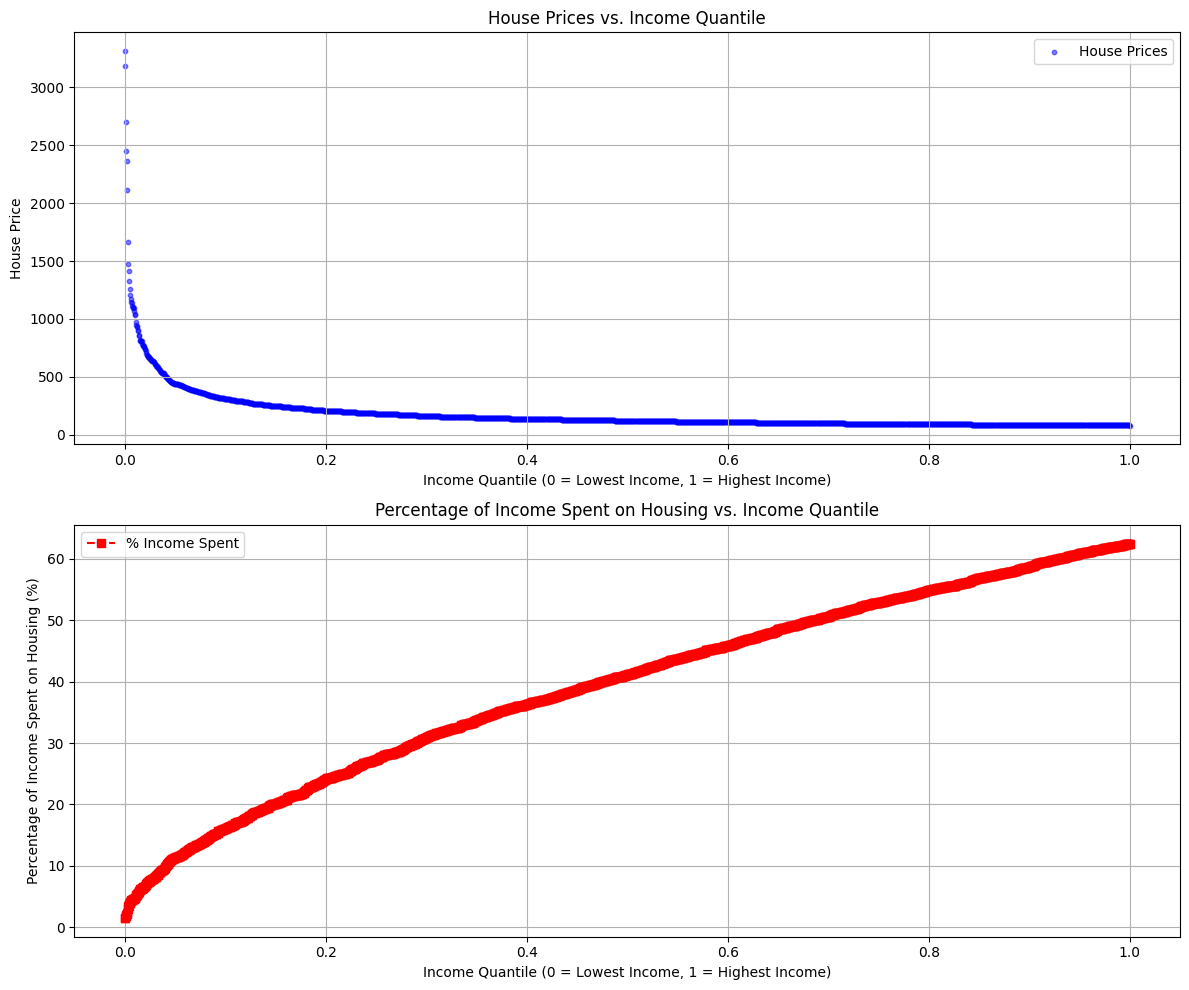

In [419]:

# Example parameters
n=2000
y_min=80
alpha=1.75
mu=10
c=50

def plot_housing_analysis(n=2000, y_min=80, alpha=1.75, mu=10, c=50, seed=1):
    # Calculate income quantiles
    income_quantiles = np.linspace(1, 0, len(y))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    # Plot 1: House Prices vs Income Quantile
    ax1.scatter(income_quantiles, y, s=10, alpha=0.5, color='b', label='House Prices')
    ax1.set_xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    ax1.set_ylabel('House Price')
    ax1.set_title('House Prices vs. Income Quantile')
    ax1.grid(True)
    ax1.legend()

    # Plot 2: Percentage of Income Spent on Housing
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (c / y) * 100, 0)  # Using c as minimum price

    ax2.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r', 
                label='% Income Spent')
    ax2.set_xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    ax2.set_ylabel('Percentage of Income Spent on Housing (%)')
    ax2.set_title('Percentage of Income Spent on Housing vs. Income Quantile')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
plot_housing_analysis(n, y_min, alpha, mu, c, seed)


## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [416]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

Congratulations! You have passed all 0 tests
